In [1]:
import tensorflow as tf
import numpy as np
from numpy import ndarray


In [4]:
class Layer:
    def __init__(self,inputNeruon: int, outputNeruon: int, g,gPrime):
        self.g = g
        self.gPrime = gPrime
        self.w = np.random.random_sample(size=(outputNeruon,inputNeruon))
        self.b = np.random.random_sample(size=(outputNeruon,1))
        self.a_0 = None
        self.z = None
    def feedFoward(self,a_0):
        self.a_0 = a_0
        self.z = self.w @ self.a_0 + self.b
        return self.g(self.z)
    def ein(self,x,y):
        return np.einsum("i,j -> ij",np.transpose(x)[0],np.transpose(y)[0])
    def backProp(self,da,alpha):
        dz = da * self.gPrime(self.z)
        newW = self.w - alpha * self.ein(dz,self.a_0)
        newB = self.b - alpha * dz
        if(np.all(np.isfinite(newW))):
            self.w = newW
        if(np.all(np.isfinite(newB))):
            self.b = newB
        return np.transpose(self.w) @ dz
class ANN:
    def __init__(self,*layer):
        self.layers = list(layer)
    def compute(self,input):
        a = input
        for l in self.layers:
            a = l.feedFoward(a)
        if(np.sum(a) == 0):
            return a
        return a/np.sum(a)
    def gradDescent(self,inputs,outputs,alpha):
        for (input,output) in zip(inputs,outputs):
            a = 2*(self.compute(input)-output)
            for i in self.layers[::-1]:
                a = i.backProp(a,alpha)
           
def Act(input):
    x = input
    mask1 = x < -0.5
    mask2 = (-0.5 <= x) & (x <= 0.5)

    result = np.zeros_like(x)  # Initialize an array of zeros
    result[mask1] = (x[mask1] + 1.5) / np.sqrt(np.e)
    result[mask2] = np.exp(x[mask2])
    result[~(mask1 | mask2)] = x[~(mask1 | mask2)] + 1
    return result
def ActPrime(input):
    x = input
    mask1 = x < -0.5
    mask2 = (-0.5 <= x) & (x <= 0.5)
    
    result = np.zeros_like(x)  # Initialize an array of zeros
    result[mask1] =  1 / np.sqrt(np.e) 
    result[mask2] = np.exp(x[mask2])
    result[~(mask1 | mask2)] = 1 
    return result
def Act2(x):
    mask = (x >= 0)
    mask1 = (x<0)
    result = np.zeros_like(x)
    result[mask] = (x[mask]+1)
    result[mask1] = np.exp(x[mask1])
    return result
def Act2Prime(x):
    mask = (x>=0)
    mask1 = (x<0)
    result = np.zeros_like(x)
    result[mask] = 1
    result[mask1] = np.exp(x[mask1])
    return result

In [5]:
model = ANN(Layer(784,15,Act2,Act2Prime),Layer(15,10,Act2,Act2Prime))

In [6]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1,1) / 255  # input for training
x_test = x_test.reshape(x_test.shape[0], -1,1) / 255  # input for testing
y_train = y_train.reshape(60_000,1)
def encode(input):
    z = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    z[0][input] = 1
    return np.transpose(z)
output_test = np.apply_along_axis(encode,1,y_train)

In [71]:
def percentAcc(model): #0.7785666666666666
    global x_train,y_train
    error = 0
    i = 0
    for (input,output) in zip(x_train,y_train):
        x = model.compute(input)
        if(not np.all(np.isfinite(x))):
            x = np.zeros_like(x)
        if(np.argmax(x) != output):
            error += 1
        i+=1
    return error
print(1-percentAcc(model)/60_000)

0.78085


In [57]:
def mse(model): #(922.5757888244711)
    global x_train,output_test
    error = 0
    for (input,output) in zip(x_train,output_test):
        diff = model.compute(input)-output
        error += np.dot(diff[0],diff[0])
    return error
print(mse(model))

988.6006748565222


In [56]:
model.gradDescent(x_train,output_test,1/120_000)

In [70]:
model.compute(x_train[1000])

array([[1.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [2.20339137e-286],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000]])

In [46]:
import copy


model2 = copy.deepcopy(model)

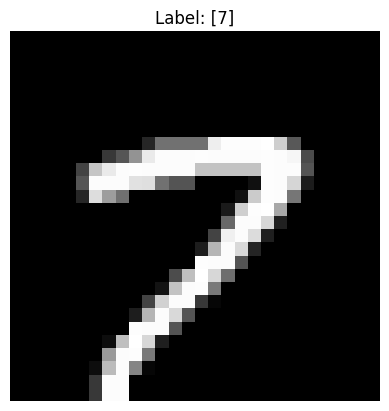

ai prediction: 7
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.97402424]
 [0.        ]
 [0.02597576]]
[[2.47775740e-05]
 [3.52514567e-06]
 [7.86538610e-06]
 [1.08379905e-04]
 [7.00867160e-05]
 [1.15560081e-03]
 [4.10325273e-07]
 [8.88352815e-01]
 [1.30354163e-03]
 [1.08972997e-01]]


In [128]:
import matplotlib.pyplot as plt
def display(index):
    img = x_train[index]
    label = y_train[index]
    if(img.shape != (28,28)):
        img = img.reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
index = 123
display(index)
print(f"ai prediction: {np.argmax(model2.compute(x_train[index]))}")
x = model2.layers[0].g(model2.layers[0].w @ (x_train[index]) + model2.layers[0].b)
x /= np.sum(x)
y = model2.layers[0].g(model2.layers[1].w @ x + model2.layers[1].b)
print(model2.compute(x_train[index]))
print(y/np.sum(y))

In [113]:
np.average(np.abs(model2.layers[0].b))

4.94925752216034

In [86]:
print(percentAcc(model2))

9819


In [64]:
error = 0
for (input, output) in zip(x_test,y_test):
    x = model2.compute(input)
    if(np.argmax(x) != output):
        error += 1
print(10_000-error)

8448


In [426]:

def ein(x,y):
    return np.einsum("i,j -> ij",np.transpose(x)[0],np.transpose(y)[0])
def envelop(x, y):
    return y * np.tile(np.transpose(x),(y.shape[0],1))